# Análisis Exploratorio de Datos - Mercado Inmobiliario

Este cuaderno realiza la limpieza y análisis exploratorio de los datos scrapeados de ZonaProp.

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import ast
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Configuración de estilo
sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## 1. Carga de Datos
En esta sección cargaremos los datos desde el archivo CSV.

In [53]:
# Leemos el dataset
try:
    df = pd.read_csv("../data/raw/real_estate_listings.csv")
    print(f"Dimensiones iniciales: {df.shape}")
    display(df.head())
except FileNotFoundError:
    print("Archivo no encontrado. Verifica la ruta.")

Dimensiones iniciales: (29999, 6)


,price,location,features,expensas,description,url
0,USD 109.000,"Palermo, Capital Federal","['32 m² tot.', '2 amb.', '1 dorm.', '1 baño']",$ 125.000 Expensas,"Departamento de dos ambientes con cocina separada por una barra, con espacio para lavarropas, heladera y cocina y anafe eléctricos. Living comedor con ventanal, baño completo y dormitorio con placard",https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-hermoso-departamento-en-venta-de-dos-ambientes-en-56926847.html?n_src=Listado&n_pills=Encargado&n_pg=1&n_pos=1
1,USD 95.243,"Villa Devoto, Capital Federal","['39 m² tot.', '1 amb.', '1 baño', '1 coch.']",$ 50.000 Expensas,"Venta departamento monoambiente A estrenar en gabriela mistral 3400, villa devoto. 3er piso al contrafrente. ubicaciónsituado en el exclusivo barrio de villa devoto, este departamento ofrece una ubica",https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-venta-departamento-3-ambientes-a-estrenar-villa-devoto-56759252.html?n_src=Listado&n_pills=Luminoso&n_pg=1&n_pos=2
2,USD 190.000,"Villa Urquiza, Capital Federal","['62 m² tot.', '2 amb.', '1 dorm.', '1 baño']",$ 1 Expensas,"Edificio Atrium Boulevard en esquina ubicado en la mejor zona de Villa Urquiza, con vista abierta frente al privilegiado Boulevard Mendoza. Ofrece unidades exclusivas con parrilla propia, además cuent",https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-dos-ambientes-con-espectacular-terraza-propia!-57749158.html?n_src=Listado&n_pills=Terraza&n_pg=1&n_pos=3
3,USD 133.984,"Belgrano, Capital Federal","['78 un.', '1 a 3 amb.', '35 a 169 m² tot.', 'Gimnasio', 'Parrilla', 'Pileta', 'Solarium', 'Balcón', 'Terraza']",NaN,"Imponente Proyecto de viviendas de gran categoría del Estudio Aisenson y mmp Desarrollos, ubicado en el corazón de Nuñez, con una excelente y céntrica ubicación en la Av. Cabildo con esquina Monroe, a",https://www.zonaprop.com.ar/propiedades/emprendimiento/ememvein-cabildo-boulevard-2502-fecha-de-entrega-2027-54112197.html?n_src=Listado&n_pg=1&n_pos=4
4,USD 175.000,"Villa Urquiza, Capital Federal","['94 m² tot.', '2 amb.', '1 dorm.', '1 baño', '1 coch.']",$ 150.000 Expensas,Venta departamento unico de 2 ambientes con balcon terraza propia de 46 M2departamento con cocheralibre reformas por reglamente de copropiedad!! departamento excelente ubicacionno dejes de mirar el vi,https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-venta-departamento-2-ambientes-con-balcon-terraza-y-57626120.html?n_src=Listado&n_pills=Terraza&n_pg=1&n_pos=5


## 2. Limpieza y Procesamiento de Datos
En esta sección limpiaremos y procesaremos los datos para poder utilizarlos de forma apropiada.

In [54]:
# 1. Limpieza de strings
df['features_clean'] = df['features'].str.replace(r"[[\]']", "", regex=True)
# Aseguramos que la descripcion sea string para evitar errores con nulos
df['description'] = df['description'].fillna('')

# 2. Función de extracción general
def extract_opt(text, pattern):
    match = re.search(fr'(\d+)\s*(?:{pattern})', text, re.IGNORECASE)
    return int(match.group(1)) if match else 0

# 3. Extracción de features 
df['m2'] = df['features_clean'].apply(lambda x: extract_opt(x, 'm²|metros'))
df['ambientes'] = df['features_clean'].apply(lambda x: extract_opt(x, 'amb'))
df['baños'] = df['features_clean'].apply(lambda x: extract_opt(x, 'baños'))
df['dormitorios'] = df['features_clean'].apply(lambda x: extract_opt(x, 'dorm'))
df['cocheras'] = df['features_clean'].apply(lambda x: extract_opt(x, 'coch'))

# 4. Limpieza de precio 
df['precio_usd'] = pd.to_numeric(df['price'].str.replace(r'[^0-9]', '', regex=True), errors='coerce')

# 5. Filtrado y Limpieza Final
df_clean = df.dropna(subset=['precio_usd']).copy()
df_clean['ubicación'] = df_clean['location']

df_clean['baños'] = df_clean['baños'].replace(0,1)

cols_finales = ['precio_usd', 'ubicación', 'm2', 'ambientes', 'dormitorios', 'baños', 'cocheras', 'expensas', 'url']
df_clean = df_clean[cols_finales].fillna(0)

df_clean.head()

,precio_usd,ubicación,m2,ambientes,dormitorios,baños,cocheras,expensas,url
0,109000.0,"Palermo, Capital Federal",32,2,1,1,0,$ 125.000 Expensas,https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-hermoso-departamento-en-venta-de-dos-ambientes-en-56926847.html?n_src=Listado&n_pills=Encargado&n_pg=1&n_pos=1
1,95243.0,"Villa Devoto, Capital Federal",39,1,0,1,1,$ 50.000 Expensas,https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-venta-departamento-3-ambientes-a-estrenar-villa-devoto-56759252.html?n_src=Listado&n_pills=Luminoso&n_pg=1&n_pos=2
2,190000.0,"Villa Urquiza, Capital Federal",62,2,1,1,0,$ 1 Expensas,https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-dos-ambientes-con-espectacular-terraza-propia!-57749158.html?n_src=Listado&n_pills=Terraza&n_pg=1&n_pos=3
3,133984.0,"Belgrano, Capital Federal",169,3,0,1,0,0,https://www.zonaprop.com.ar/propiedades/emprendimiento/ememvein-cabildo-boulevard-2502-fecha-de-entrega-2027-54112197.html?n_src=Listado&n_pg=1&n_pos=4
4,175000.0,"Villa Urquiza, Capital Federal",94,2,1,1,1,$ 150.000 Expensas,https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-venta-departamento-2-ambientes-con-balcon-terraza-y-57626120.html?n_src=Listado&n_pills=Terraza&n_pg=1&n_pos=5


## 3. Análisis Exploratorio de Datos (EDA)
En esta sección generaremos nuevas variables y realizaremos un análisis exhaustivo de los datos inmobiliarios.

In [55]:
# 1. Feature Engineering: Creación de nuevas variables

# Precio por m2 (Dólares / m2)
# Filtramos propiedades con m2 > 0 para evitar divisiones por cero
df_clean = df_clean[df_clean['m2'] > 0].copy()
df_clean['precio_m2'] = df_clean['precio_usd'] / df_clean['m2']

# Relación cantidad de ambientes por m2
df_clean['ambientes_m2'] = df_clean['ambientes'] / df_clean['m2']

# Extracción del nombre del Barrio desde la columna 'ubicación'
df_clean['barrio'] = df_clean['ubicación'].apply(lambda x: x.split(',')[0].strip() if isinstance(x, str) else 'Desconocido')

print(f"Cantidad de barrios identificados: {df_clean['barrio'].nunique()}")
print("Variables creadas: precio_m2, ambientes_m2, barrio")
display(df_clean[['ubicación', 'barrio', 'precio_usd', 'm2', 'precio_m2']].head())

Cantidad de barrios identificados: 82
Variables creadas: precio_m2, ambientes_m2, barrio


,ubicación,barrio,precio_usd,m2,precio_m2
0,"Palermo, Capital Federal",Palermo,109000.0,32,3406.250000
1,"Villa Devoto, Capital Federal",Villa Devoto,95243.0,39,2442.128205
2,"Villa Urquiza, Capital Federal",Villa Urquiza,190000.0,62,3064.516129
3,"Belgrano, Capital Federal",Belgrano,133984.0,169,792.804734
4,"Villa Urquiza, Capital Federal",Villa Urquiza,175000.0,94,1861.702128


### 3.1 Identificación de Valores Atípicos (Outliers)
Visualizamos la distribución de las variables clave para detectar valores extremos que puedan sesgar el análisis.

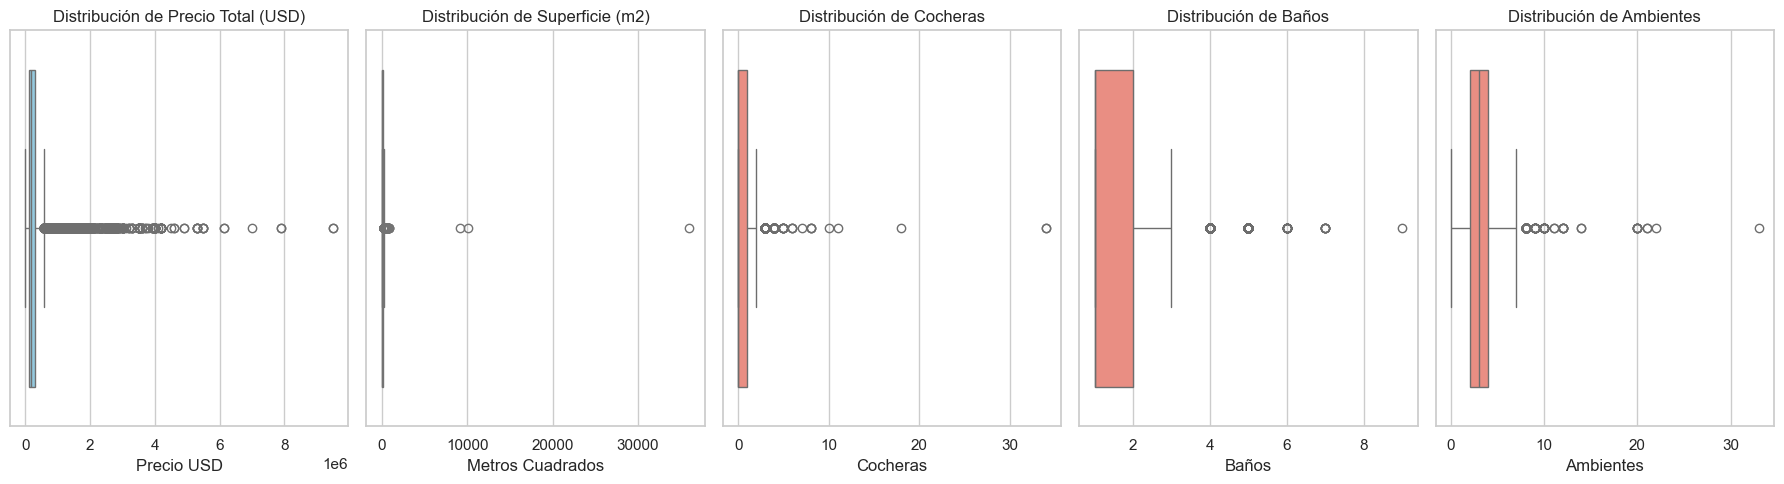

In [56]:
fig, axes = plt.subplots(1, 5, figsize=(18, 5))

# Boxplot Precio Total
sns.boxplot(x=df_clean['precio_usd'], ax=axes[0], color='skyblue')
axes[0].set_title('Distribución de Precio Total (USD)')
axes[0].set_xlabel('Precio USD')

# Boxplot Superficie
sns.boxplot(x=df_clean['m2'], ax=axes[1], color='lightgreen')
axes[1].set_title('Distribución de Superficie (m2)')
axes[1].set_xlabel('Metros Cuadrados')

# Boxplot Cocheras
sns.boxplot(x=df_clean['cocheras'], ax=axes[2], color='salmon')
axes[2].set_title('Distribución de Cocheras')
axes[2].set_xlabel('Cocheras')

# Boxplot Baños
sns.boxplot(x=df_clean['baños'], ax=axes[3], color='salmon')
axes[3].set_title('Distribución de Baños')
axes[3].set_xlabel('Baños')

# Boxplot Ambientes
sns.boxplot(x=df_clean['ambientes'], ax=axes[4], color='salmon')
axes[4].set_title('Distribución de Ambientes')
axes[4].set_xlabel('Ambientes')

plt.tight_layout()
plt.show()


### 3.2 Limpieza de Outliers

In [57]:
# Identificar Outliers
# Creamos un filtro para identificar outliers
filtro_outliers = (
    (df_clean['precio_usd'] < 20000) | 
    (df_clean['m2'] > 5000) | 
    (df_clean['cocheras'] > 6) | 
    (df_clean['baños'] > 6) | 
    (df_clean['ambientes'] > 12)
)

df_outliers = df_clean[filtro_outliers]

print(f"Se identificaron {len(df_outliers)} propiedades como outliers extremos.")
display(df_outliers.head(10))

# Extraer urls
urls_outliers = df_outliers['url']
for url in urls_outliers:
    print(url)

# Eliminar outliers
df_clean = df_clean.drop(df_outliers.index)

Se identificaron 46 propiedades como outliers extremos.


,precio_usd,ubicación,m2,ambientes,dormitorios,baños,cocheras,expensas,url,precio_m2,ambientes_m2,barrio
367,15000.0,"Villa del Parque, Capital Federal",80,3,0,1,0,0,https://www.zonaprop.com.ar/propiedades/emprendimiento/ememvein-sm-4820-54795693.html?n_src=Listado&n_pg=13&n_pos=8,187.500000,0.037500,Villa del Parque
1287,95000.0,"Villa Crespo, Capital Federal",46,1,0,1,34,$ 170.000 Expensas,https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-monoambiente-divisible-en-venta-apto-profesional-full-57873101.html?n_src=Listado&n_pills=SUM&n_pg=43&n_pos=28,2065.217391,0.021739,Villa Crespo
1347,1000000.0,"Palermo, Capital Federal",512,8,5,7,2,$ 1.300.000 Expensas,https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-venta-duplex-belgrano-zona-de-embajadas-2-cocheras-57984733.html?n_src=Listado&n_pills=Parrilla&n_pg=45&n_pos=28,1953.125000,0.015625,Palermo
1392,75000.0,"Almagro, Capital Federal",29,1,0,1,8,$ 160.000 Expensas,https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-venta-amplio-monoambiente-con-guardacoche-incluido-en-57986165.html?n_src=Listado&n_pills=Terraza&n_pg=47&n_pos=13,2586.206897,0.034483,Almagro
2453,3950000.0,"Palermo Nuevo, Palermo",400,6,4,7,3,$ 3.000.000 Expensas,https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-venta-le-parc-demaria-exclusivo-piso-alto-5-amb-55937666.html?n_src=Listado&n_pills=Dormitorio+en+suite&n_pg=82&n_pos=24,9875.000000,0.015000,Palermo Nuevo
3667,15000.0,"Villa del Parque, Capital Federal",80,3,0,1,0,0,https://www.zonaprop.com.ar/propiedades/emprendimiento/ememvein-sm-4820-54795693.html?n_src=Listado&n_pg=123&n_pos=8,187.500000,0.037500,Villa del Parque
4998,1950000.0,"Belgrano, Capital Federal",425,7,5,7,3,$ 17.900 Expensas,https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-oppel-departamento-en-venta-belgrano-capital-44930233.html?n_src=Listado&n_pills=Dormitorio+en+suite&n_pg=167&n_pos=19,4588.235294,0.016471,Belgrano
5129,530000.0,"Palermo, Capital Federal",117,4,3,3,11,0,https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-nuevo-ingreso-palermo-view-57870673.html?n_src=Listado&n_pills=SUM&n_pg=171&n_pos=30,4529.914530,0.034188,Palermo
5314,95000.0,"Villa Crespo, Capital Federal",46,1,0,1,34,$ 170.000 Expensas,https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-monoambiente-divisible-en-venta-apto-profesional-full-57873101.html?n_src=Listado&n_pills=Laundry&n_pg=178&n_pos=5,2065.217391,0.021739,Villa Crespo
5718,3950000.0,"Palermo Nuevo, Palermo",400,6,4,7,3,$ 3.000.000 Expensas,https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-venta-le-parc-demaria-exclusivo-piso-alto-5-amb-55937666.html?n_src=Listado&n_pills=Dormitorio+en+suite&n_pg=191&n_pos=19,9875.000000,0.015000,Palermo Nuevo


https://www.zonaprop.com.ar/propiedades/emprendimiento/ememvein-sm-4820-54795693.html?n_src=Listado&n_pg=13&n_pos=8
https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-monoambiente-divisible-en-venta-apto-profesional-full-57873101.html?n_src=Listado&n_pills=SUM&n_pg=43&n_pos=28
https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-venta-duplex-belgrano-zona-de-embajadas-2-cocheras-57984733.html?n_src=Listado&n_pills=Parrilla&n_pg=45&n_pos=28
https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-venta-amplio-monoambiente-con-guardacoche-incluido-en-57986165.html?n_src=Listado&n_pills=Terraza&n_pg=47&n_pos=13
https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-venta-le-parc-demaria-exclusivo-piso-alto-5-amb-55937666.html?n_src=Listado&n_pills=Dormitorio+en+suite&n_pg=82&n_pos=24
https://www.zonaprop.com.ar/propiedades/emprendimiento/ememvein-sm-4820-54795693.html?n_src=Listado&n_pg=123&n_pos=8
https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-op

### 3.3 Segmentación Geográfica
Analizamos el precio promedio y el valor del m² agrupados por barrio. Esto permite identificar zonas premium y oportunidades de inversión.

Top 10 Barrios más caros por m2:


,precio_usd,precio_m2,cantidad
barrio,,,
Puerto Madero,9.051732e+05,5602.990204,1011
Barrio Parque,1.500413e+06,4983.075950,46
Palermo Nuevo,6.913632e+05,4305.296059,74
Palermo Chico,6.951549e+05,4151.005749,742
Distrito Quartier,1.953000e+05,3804.150548,5
Belgrano Chico,3.833254e+05,3575.372423,18
Núñez,4.132230e+05,3405.745388,1349
Las Cañitas,3.916301e+05,3275.931866,577
Palermo,3.866710e+05,3205.041631,2457


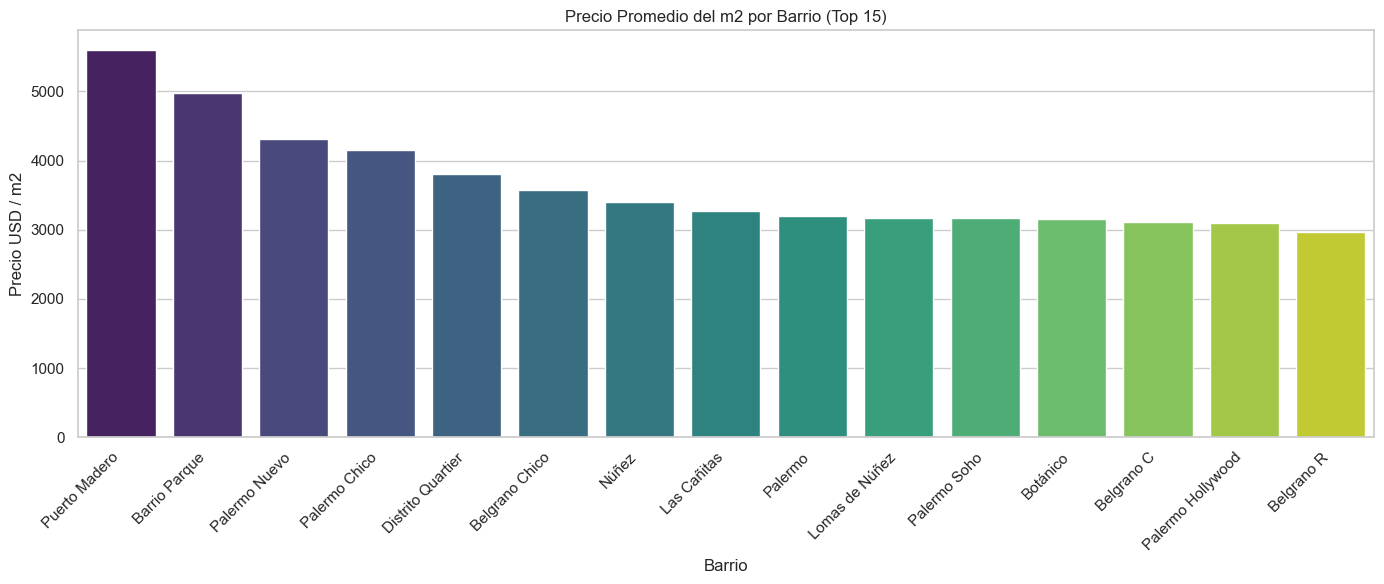

In [58]:
# Agrupamos por barrio y calculamos medias
barrio_stats = df_clean.groupby('barrio').agg({
    'precio_usd': 'mean',
    'precio_m2': 'mean',
    'ubicación': 'count' 
}).rename(columns={'ubicación': 'cantidad'}).sort_values('precio_m2', ascending=False)

# Filtramos solo barrios con una cantidad mínima representativa de datos
barrio_stats = barrio_stats[barrio_stats['cantidad'] > 0]

print("Top 10 Barrios más caros por m2:")
display(barrio_stats.head(10))

# Visualización de los Top 15 Barrios por Precio m2
plt.figure(figsize=(14, 6))
top_barrios = barrio_stats.head(15)
sns.barplot(x=top_barrios.index, y=top_barrios['precio_m2'], hue=top_barrios.index, palette='viridis', legend=False)
plt.xticks(rotation=45, ha='right')
plt.title('Precio Promedio del m2 por Barrio (Top 15)')
plt.ylabel('Precio USD / m2')
plt.xlabel('Barrio')
plt.tight_layout()
plt.show()

### 3.4 Drivers de Valor: Impacto de Cocheras y Baños
Evaluamos cómo la presencia de cochera y la cantidad de baños influyen en el precio de la propiedad.

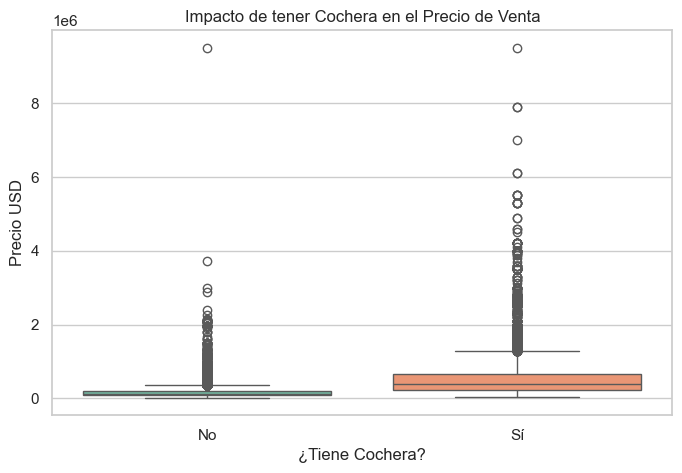

In [59]:
# Crear variable categórica para 'Tiene Cochera'
df_clean['tiene_cochera'] = df_clean['cocheras'].apply(lambda x: 'Sí' if x > 0 else 'No')

# Visualización: Precio vs Cochera
plt.figure(figsize=(8, 5))
sns.boxplot(x='tiene_cochera', y='precio_usd', data=df_clean, palette='Set2', hue='tiene_cochera')
plt.title('Impacto de tener Cochera en el Precio de Venta')
plt.ylabel('Precio USD')
plt.xlabel('¿Tiene Cochera?')
plt.show()


### 3.5 Matriz de Correlación
Analizamos la relación lineal entre las variables numéricas.

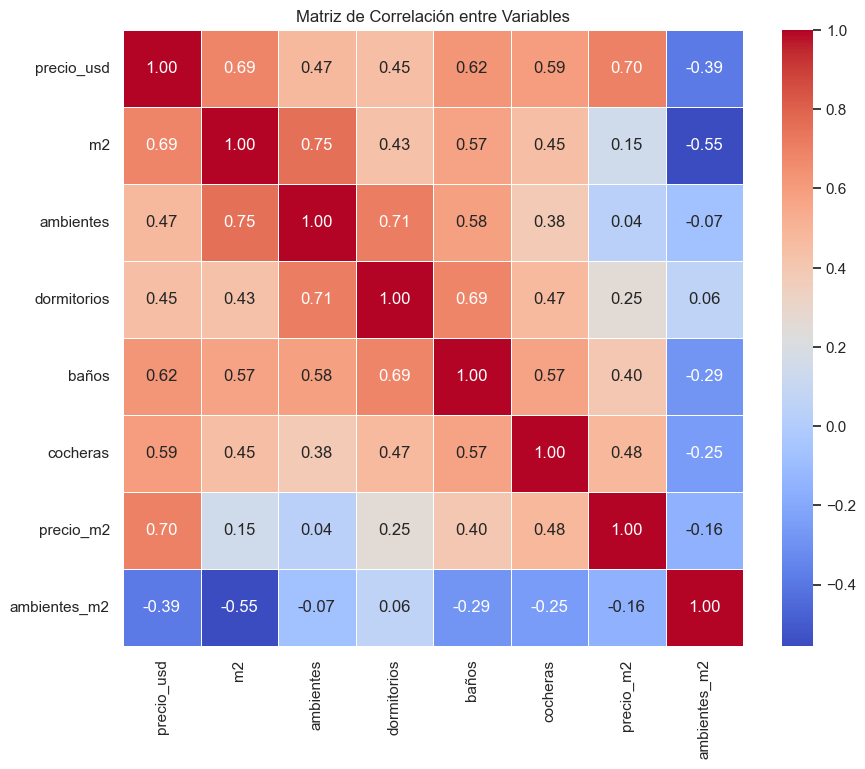

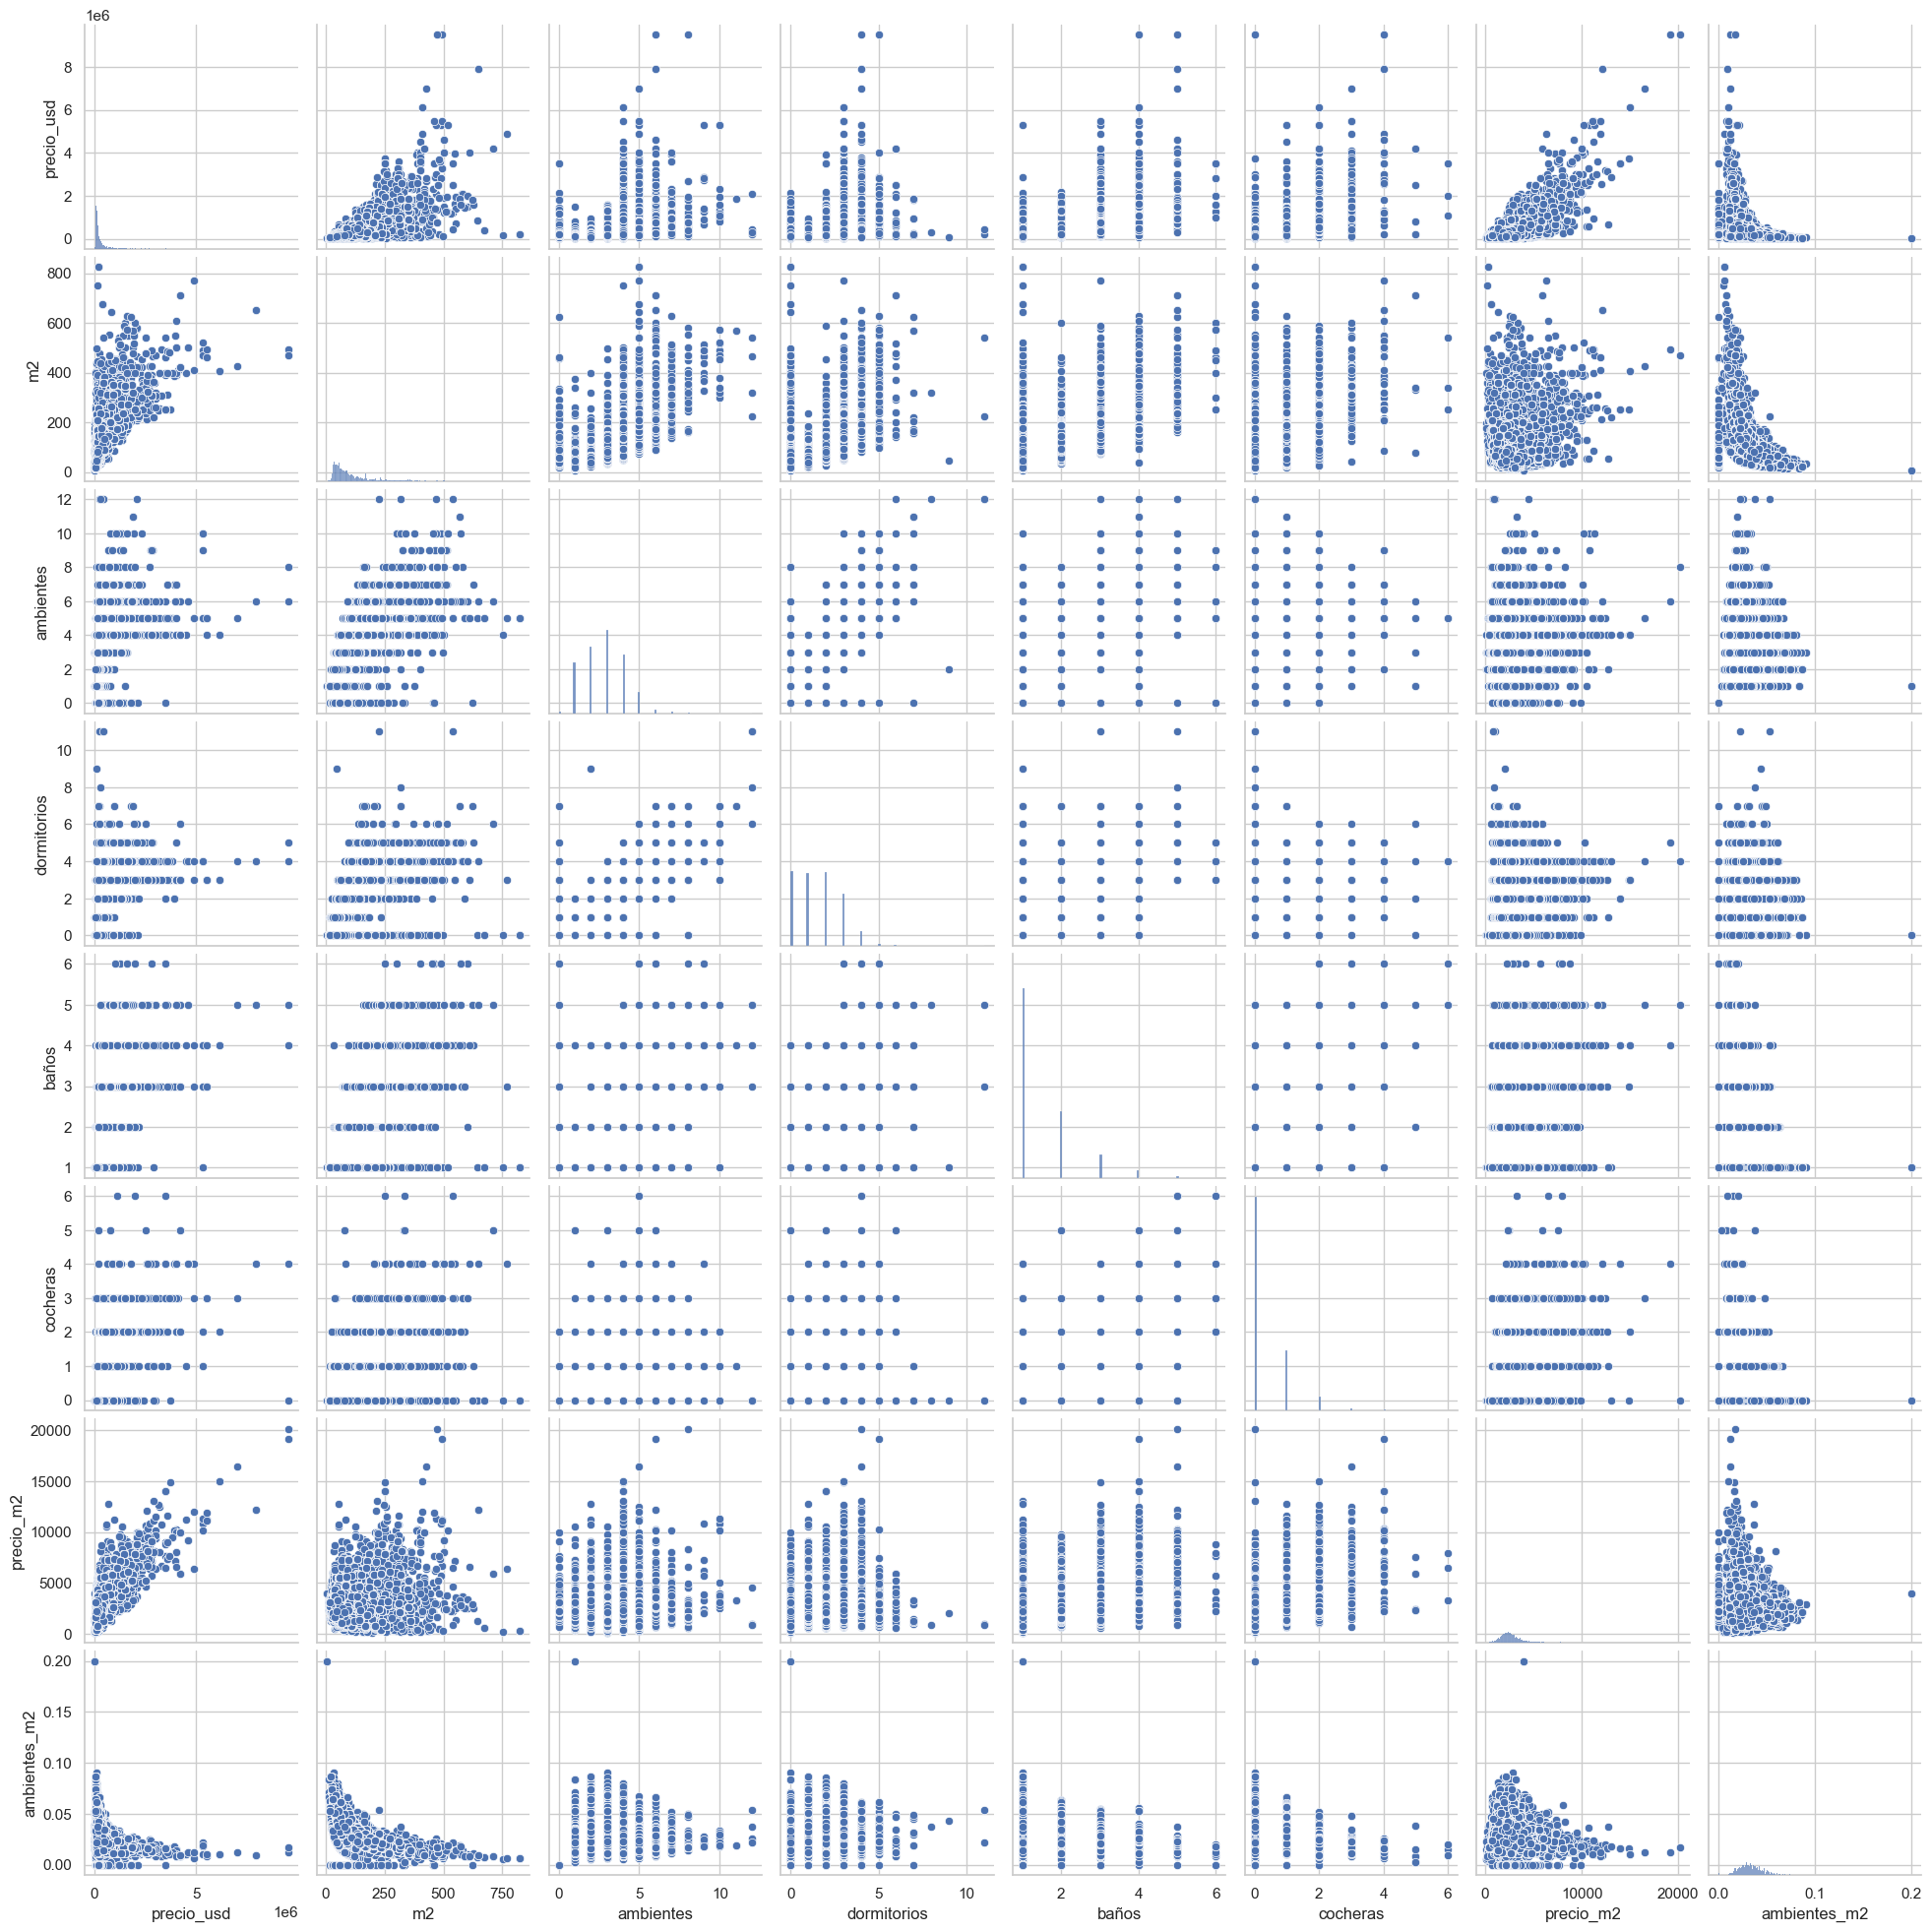

In [60]:
# Seleccionamos variables numéricas relevantes
vars_corr = ['precio_usd', 'm2', 'ambientes', 'dormitorios', 'baños', 'cocheras', 'precio_m2','ambientes_m2']
corr_matrix = df_clean[vars_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación entre Variables')
plt.show()

# Relaciones entre variables numéricas
sns.pairplot(df_clean)

## 4. Regresiones Lineales
Predicción del precio de propiedades utilizando regresiones lineales

### Regresiones Lineales Simples

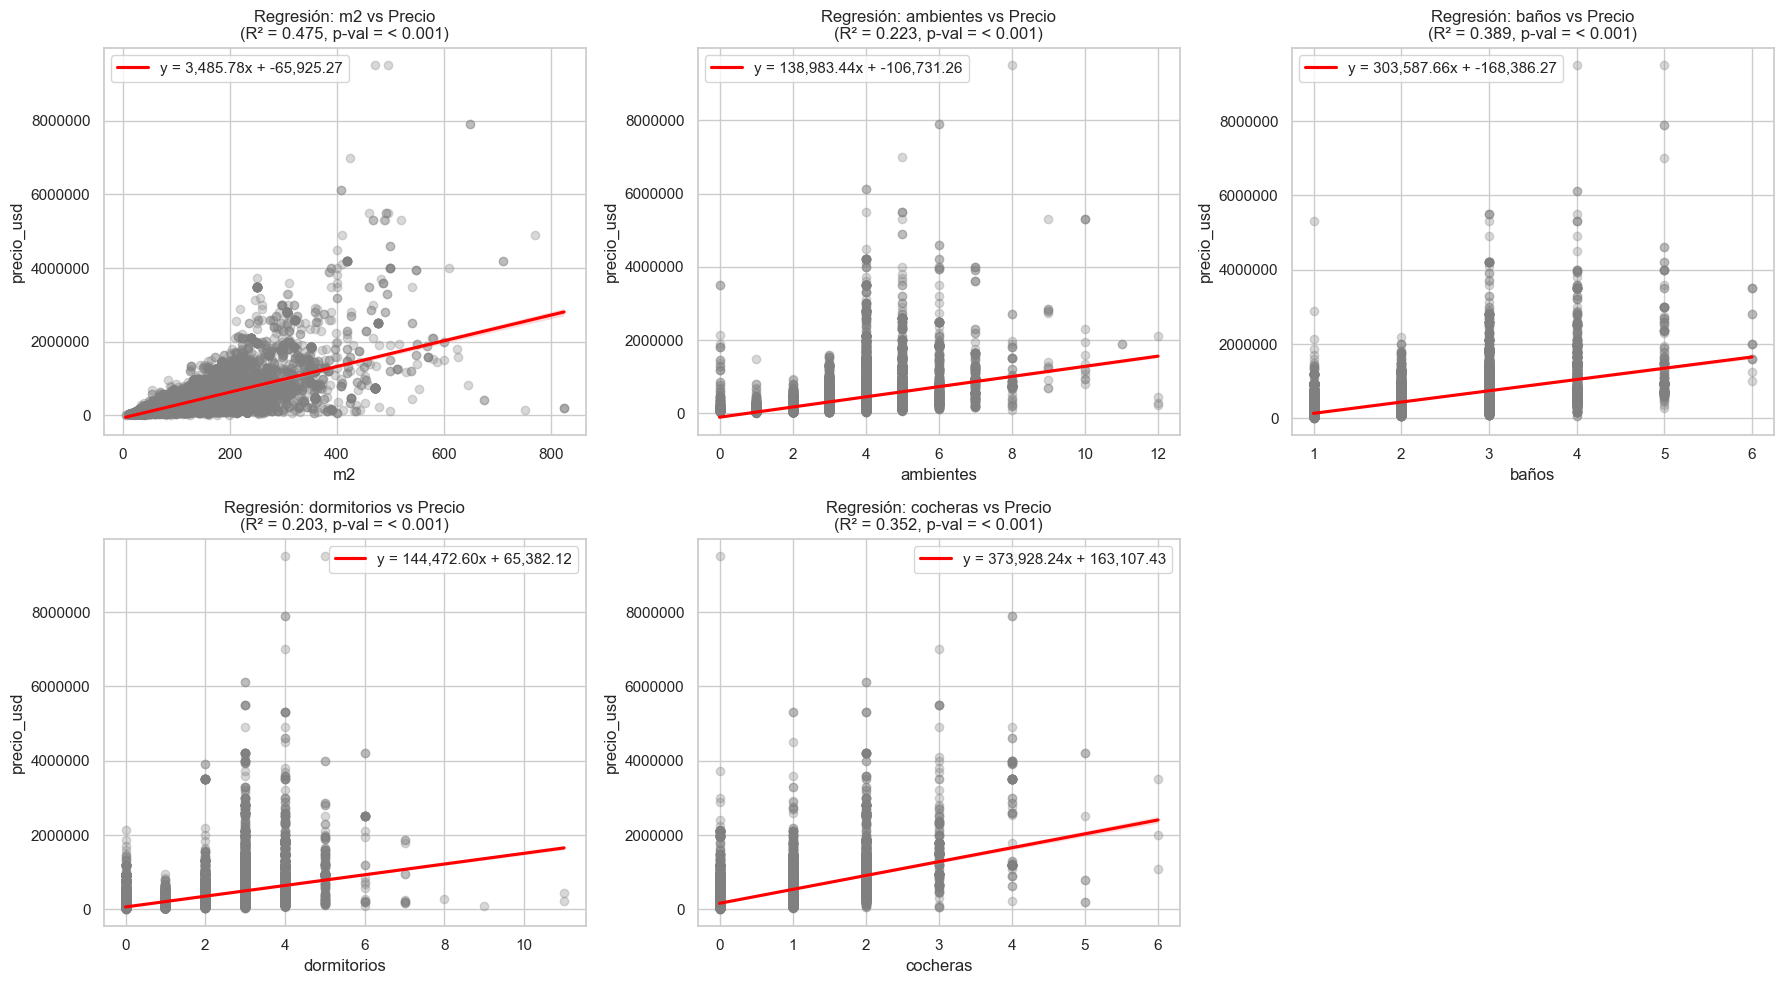

In [61]:
# Regresion Lineal Simple con R2 y p-value
variables = ['m2', 'ambientes', 'baños', 'dormitorios', 'cocheras']
target = 'precio_usd'

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, var in enumerate(variables):
    X_simple = sm.add_constant(df_clean[[var]])
    y = df_clean[target]
    
    model_simple = sm.OLS(y, X_simple).fit()
    
    intercepto = model_simple.params['const']
    pendiente = model_simple.params[var]
    r2 = model_simple.rsquared
    
    # Extraer el p-value de la variable independiente 
    p_valor = model_simple.pvalues[var]
    
    # Formatear el p-value para que sea legible
    p_texto = f"{p_valor:.3f}" if p_valor >= 0.001 else "< 0.001"
    
    sns.regplot(ax=axes[i], x=var, y=target, data=df_clean, 
                scatter_kws={'alpha':0.3, 'color':'gray'}, 
                line_kws={'color':'red', 'label':f'y = {pendiente:,.2f}x + {intercepto:,.2f}'})
    
    # Añadir p-value al título
    axes[i].set_title(f'Regresión: {var} vs Precio\n(R² = {r2:.3f}, p-val = {p_texto})')
    axes[i].legend()
    axes[i].ticklabel_format(style='plain', axis='y') 

fig.delaxes(axes[5])
plt.tight_layout()
plt.show()


## Regresiones Lineales Multiples 

### Regresion lineal multiple Log-Lin

In [62]:
# Sin Variables Dummies

# 1. Transformación Logarítmica (Soluciona Heterocedasticidad)
df_clean['log_precio'] = np.log(df_clean['precio_usd'])

# 2. Selección de variables
features = ['m2', 'baños', 'ambientes', 'cocheras']
X = df_clean[features]
X = sm.add_constant(X)

# 3. Verificación de VIF (Debe ser < 5 para estar tranquilos)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print("Factores de Inflación de la Varianza (VIF):")
print(vif_data)

# 4. Ajuste del Modelo Múltiple
modelo_log_sin_dummies= sm.OLS(df_clean['log_precio'], X).fit()

# 5. Resumen con Errores Estándar Robustos (Refuerzo contra Heterocedasticidad)
print(modelo_log_sin_dummies.get_robustcov_results(cov_type='HC3').summary())

Factores de Inflación de la Varianza (VIF):
     feature       VIF
0      const  6.868042
1         m2  2.545462
2      baños  1.976929
3  ambientes  2.510603
4   cocheras  1.541636
                            OLS Regression Results                            
Dep. Variable:             log_precio   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                 1.029e+04
Date:                Wed, 07 Jan 2026   Prob (F-statistic):               0.00
Time:                        10:27:14   Log-Likelihood:                -17615.
No. Observations:               29757   AIC:                         3.524e+04
Df Residuals:                   29752   BIC:                         3.528e+04
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                 coef    std

In [63]:
# Con Varibles Dummies

# 1. Transformación Logarítmica (Soluciona Heterocedasticidad)
df_clean['log_precio'] = np.log(df_clean['precio_usd'])

# 2. Selección de variables y creación de variables dummy para 'barrio'
# drop_first=True es fundamental para evitar la trampa de la variable ficticia (multicolinealidad perfecta)
barrios_dummies = pd.get_dummies(df_clean['barrio'], prefix='barrio', drop_first=True)
features = ['m2', 'baños', 'ambientes', 'cocheras']
X = pd.concat([df_clean[features], barrios_dummies], axis=1).astype(float)
X = sm.add_constant(X)

# 3. Verificación de VIF (Debe ser < 5 para estar tranquilos)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print("Factores de Inflación de la Varianza (VIF):")
print(vif_data)

# 4. Ajuste del Modelo Múltiple
modelo_log_con_dummies = sm.OLS(df_clean['log_precio'], X).fit()

# 5. Resumen con Errores Estándar Robustos (Refuerzo contra Heterocedasticidad)
print(modelo_log_con_dummies.get_robustcov_results(cov_type='HC3').summary())

Factores de Inflación de la Varianza (VIF):
                    feature         VIF
0                     const  391.438166
1                        m2    2.771415
2                     baños    2.046591
3                 ambientes    2.670751
4                  cocheras    1.622129
..                      ...         ...
81        barrio_Villa Real    1.038873
82  barrio_Villa Santa Rita    2.522927
83     barrio_Villa Soldati    1.065040
84     barrio_Villa Urquiza   17.562962
85  barrio_Villa del Parque    6.079679

[86 rows x 2 columns]
                            OLS Regression Results                            
Dep. Variable:             log_precio   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     1372.
Date:                Wed, 07 Jan 2026   Prob (F-statistic):               0.00
Time:                        10:27:31   Log-Likelihood:   

c:\Users\guard\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 85, but rank is 84
  warnings.warn('covariance of constraints does not have full '
